## Tips and Hints
The MAV structure created from the import statement below will have all of your physical parameters (i.e., `MAV.mass` and `MAV.Jx`).
```mav_sim.parameters.aerosonde_parameters as MAV```

Note footnote 2 at the bottom of page 57 in Section 4.3 as well as the units of KV as described in aerosonde_parameters.py. The value $K_Q^2$ may come in handy as might the text right before the footnote.

Recall the error in the final equation of Section 4.3. It should read $\bf{m}_p = (-Q_p, 0, 0)^T$

You must put the ch04_test_archive.pkl file inside the mavsim_python\mav_sim\unit_tests folder. This file can be found on canvas under Files->Unit_tests.

It is often easier to debug the code using the debugger and run the code in python instead of through the Jupyter file. 

## Problem 0: Implementation of Forces and Moments
Implement the `forces_moments`, `gravitational_force`, `lateral_aerodynamics`, `longitudinal_aerodynamics`, `motor_thrust_torque`, and `update_velocity_data` functions in `chap4/mav_dynamics.py` as described in chapter 4. For the aerodynamic coefficients $C_L(\alpha)$ and $C_D(\alpha)$, use equations (4.9) and (4.11), respectively.

Keep in mind that there was an error in the book when listing the propulsion moment. The propulsion moment should read $m_p = (-Q_p, 0, 0)^T$.

Below are some useful code snippets and hints:
* R = Quaternion2Rotation(self._state[IND.QUAT]) # computes the rotation from body to world frame
* uvw = state[IND.VEL] # Extracts the u-v-w body axis velocities from the state vector
* MAV contains the UAV parameters (i.e., MAV.mass gives the mass and MAV.gravity is the gravity constant)
* In `forces_moments`, you will need to calculate the following:
  * gravitaional forces
  * Lift and Drag Forces
  * longitudinal forces and torques
  * lateral forces and torques
* In `motor_thrust_torque` you will do the following
  * Use the quadratic formulate to solve for motor speed
  * Use the resulting values to compute the angular speed of the propeller
  * Compute and return the thruse and torque due to the propeller
* In `update_velocity_data` you will do the following
  * Convert the wind vector to the body frame
  * Compute the airspeed
  * Compute the angle of attack
  * Compute the sideslip angle

Running the simulator requires passing a function that takes in a time value and produces a command. We'll learn about trim later, but trim trajectories are trajectories that can be flown with constant inputs. In reality the trim inputs can only be used for a small amount of time without any feedback due to disturbances. Once implemented, the following code will produce a trajectory that flights straight and steady without any need for modification.

In [10]:
# Note that this cell can be run separately to initialize for other cell blocks
import numpy as np
from mav_sim.chap3.mav_dynamics import DynamicState
from mav_sim.chap4.run_sim import run_sim
from mav_sim.message_types.msg_delta import MsgDelta
from mav_sim.message_types.msg_sim_params import MsgSimParams
from mav_sim.message_types.msg_gust_params import MsgGustParams
from mav_sim.tools.display_figures import display_data_view, display_mav_view
from mav_sim.chap2.mav_viewer import MavViewer
from mav_sim.chap3.data_viewer import DataViewer

# The viewers need to be initialized once due to restart issues with qtgraph
if 'mav_view' not in globals():
    print("Initializing mav_view")
    global mav_view
    mav_view = MavViewer()  # initialize the mav viewer
if 'data_view' not in globals():
    print("Initializing data_view")
    global data_view
    data_view = DataViewer()  # initialize view of data plots

# Initialize state values
sim_params = MsgSimParams(end_time=40.) # Sim ending in 40 seconds
state = DynamicState()

# Functions used below
def run_sim_and_display(delta_fnc, use_wind = False, gust_params = None):
    global mav_view
    global data_view
    data_view.reset(sim_params.start_time)
    (mav_view, data_view) = run_sim(sim_params, delta_fnc, state, mav_view, data_view, use_wind, gust_params)
    display_data_view(data_view)
    display_mav_view(mav_view)

def trim(time: float)->MsgDelta:
    """Passes out the constant trim command
    """
    # Set control surfaces
    delta = MsgDelta()
    delta.elevator = -0.1248
    delta.aileron = 0.001836
    delta.rudder = -0.0003026
    delta.throttle = 0.6768
    return delta

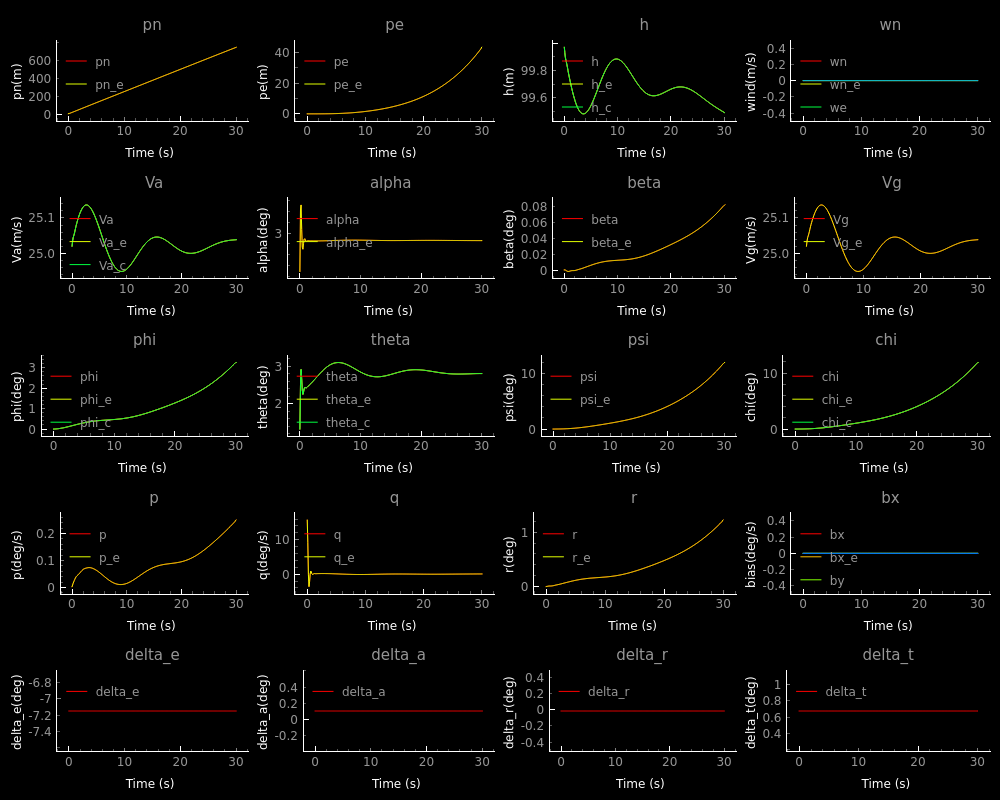

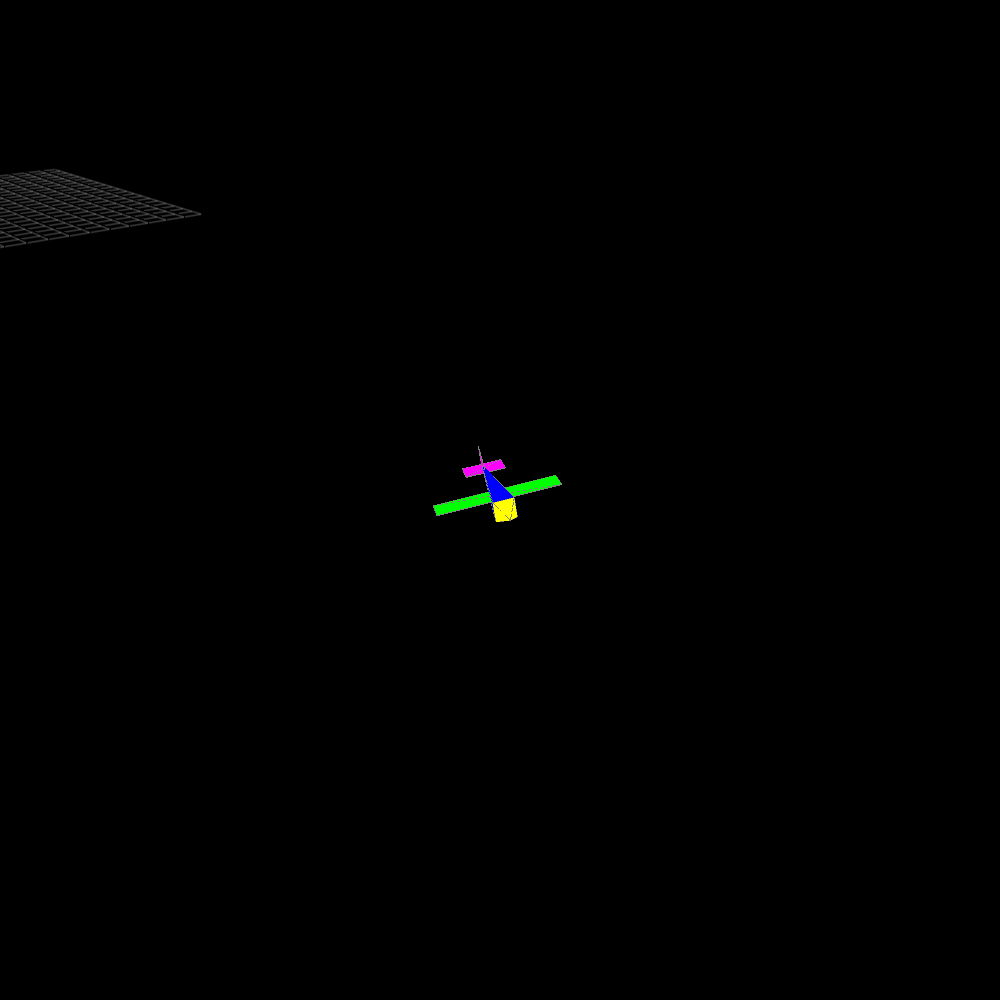

In [2]:
# Run a "straight" trim trajectory
run_sim_and_display(trim)

## Problem 1: Effect of the elevator control surface
This problem varies the elevator value during flight of the aircraft. Design a function that will perturb the elevator control surface by 5 degrees in the negative direction after 5 seconds and 5 degrees in the positive direction after 15 seconds.

### Question: Given the definitions of positive control surface deflection from chapter 4, what behavior do you expect for the altitude, Y-axis angular velocity, airspeed, and pitch angle?
**Answer:** Y axis angular velocity will increase with the elevator. Altitude will increase aswell, pitch angle will go negitive. While airspeed will decrease

Run the simulation and verify the expected behavior.

### Question: Was the behavior as expected? If not, what did you observe differently from what you thought you would? Why did this difference occur?
**Answer:** Nope it make sense, as the elevator goes negitive the aircraft goes up and as it goes positive the aircreaft goes down fast.



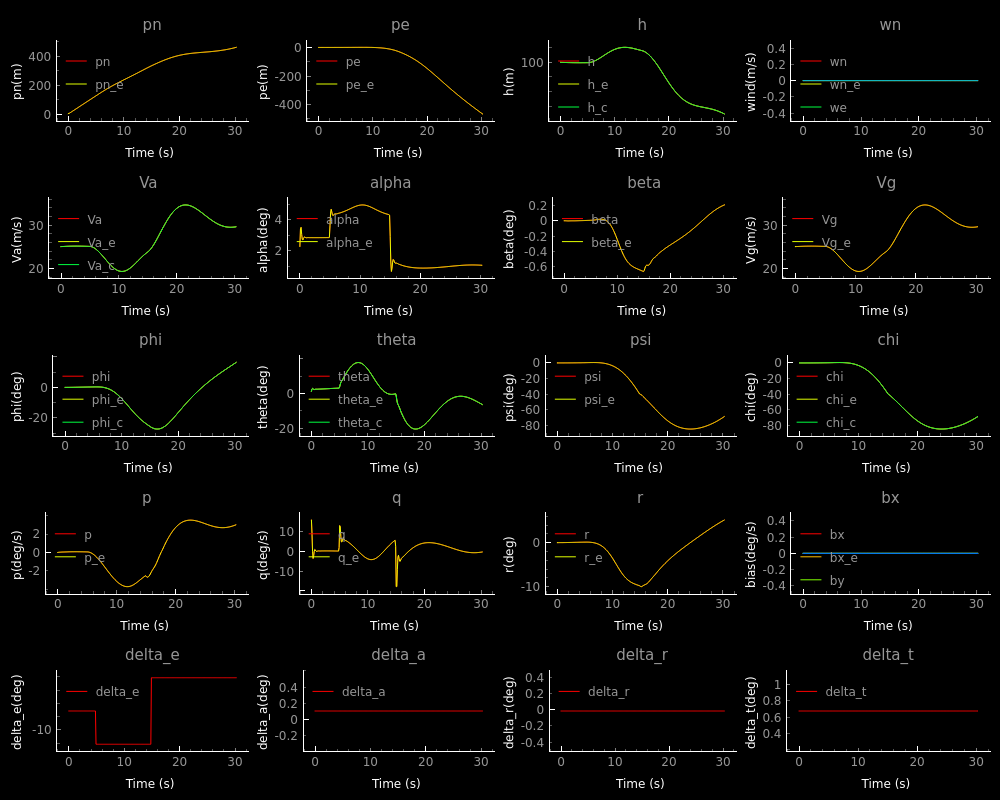

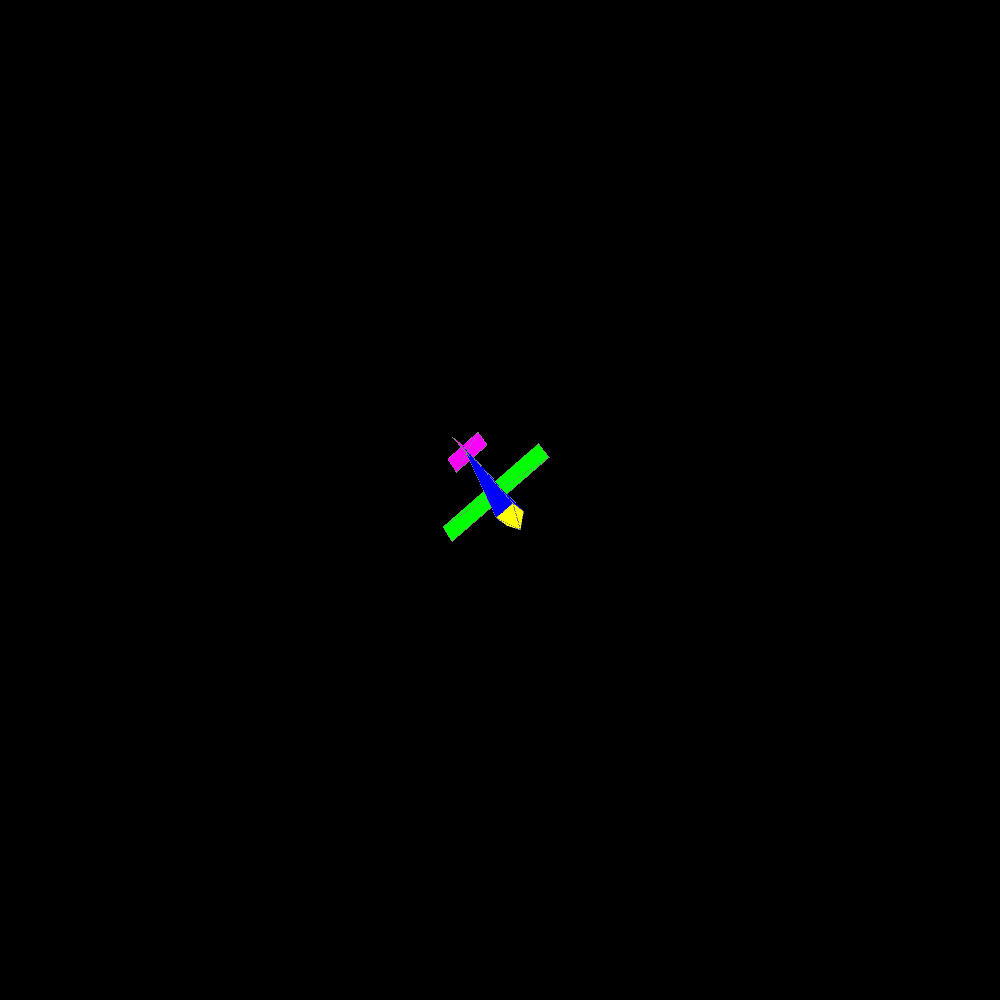

In [3]:
def perturb_elevator(time: float) -> MsgDelta:
    """ Perturb the elevator trim commands by
            -5 degrees      5 < time <= 15
            5  degrees      15 < time
    """
    delta = trim(time)
    if time > 15.:
        delta.elevator += 5*np.pi/180. # Perturb up by 5 degrees
    elif time > 5:
        delta.elevator += -5*np.pi/180. # Perturb down by 5 degrees
    return delta

# Perturb the elevator
run_sim_and_display(perturb_elevator)

## Problem 2: Effect of the aileron control surface
This problem varies the aileron value during flight of the aircraft.  Design a function that will perturb the aileron control surface by 0.2 degrees in the negative direction after 5 seconds and 0.2 degrees in the positive direction after 15 seconds.

### Question: Given the definitions of positive control surface deflection from chapter 4, what behavior do you expect for X-axis angular velocity, roll angle, and heading?
**Answer:** As the aileron is positive, the X-axis angular velocity will go positve. The roll angle will also increase and the heading will go negitive. The opposite is true for negitive aileron

Run the simulation and verify the expected behavior.

### Question: Was the behavior as expected? If not, what did you observe differently from what you thought you would? Why did this difference occur?
**Answer:** The heading angle will actually go positive. This occured because I think the airplane actually fips around.

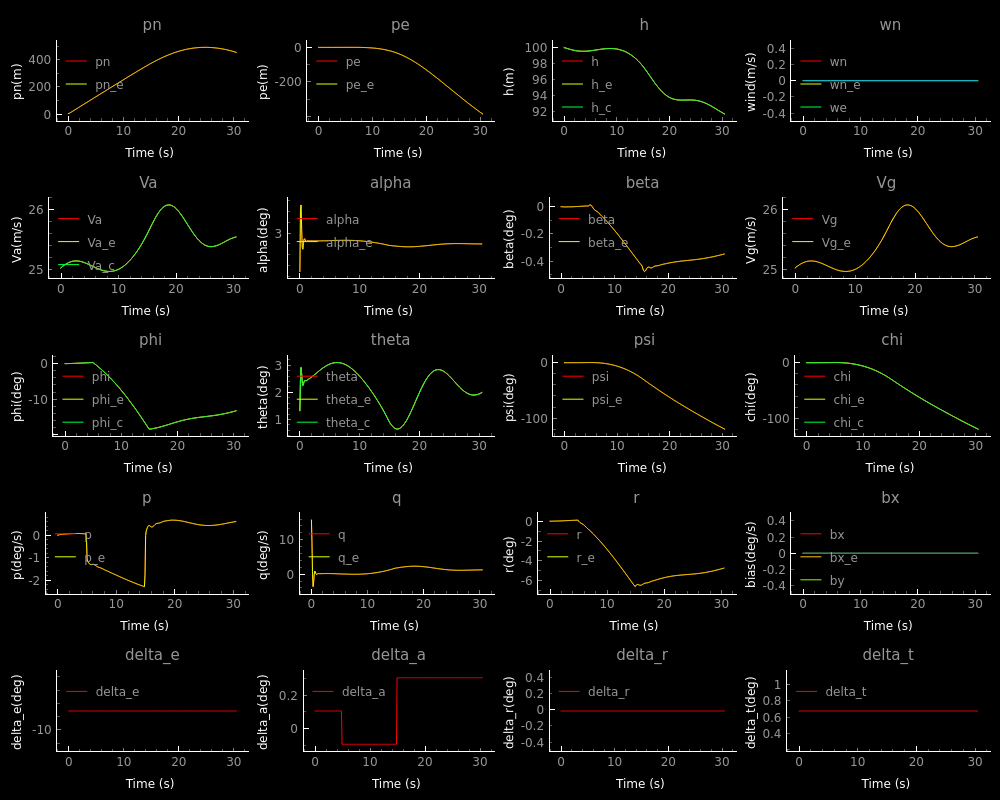

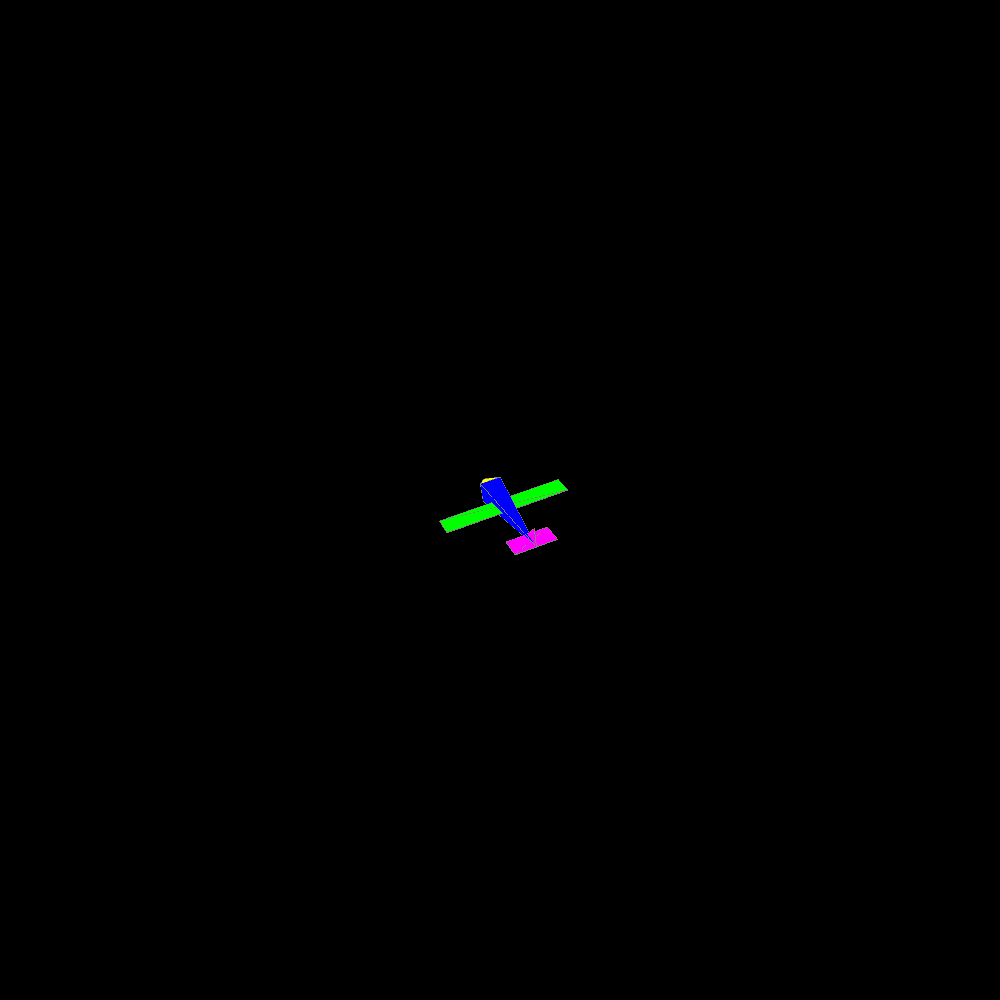

In [4]:
def perturb_aileron(time: float) -> MsgDelta:
    """ Perturb the aileron trim commands by
            -0.2 degrees      5 < time <= 15
            0.2  degrees      15 < time
    """
    # Calculate the trim trajectory
    delta = trim(time)

    # Perturb the control
    if time > 15.:
        delta.aileron += 0.2*np.pi/180. # Perturb up by 0.2 degrees
    elif time > 5:
        delta.aileron += -0.2*np.pi/180. # Perturb down by 0.2 degrees

    # Return the perturbed control
    return delta

# Perturb the elevator
run_sim_and_display(perturb_aileron)

## Problem 3: Effect of the rudder control surface
This problem varies the rudder value during flight of the aircraft.  Design a function that will perturb the rudder control surface by 0.2 degrees in the negative direction after 5 seconds and 0.2 degrees in the positive direction after 15 seconds.

### Question: Given the definitions of positive control surface deflection from chapter 4, what behavior do you expect for Z-axis angular velocity, heading angle, and roll angle?
**Answer:** As the rudder is positive. The Z-axis angular velocity will increase, the heading angle will increase, and the roll angle will increase. The reverse is true for a negitive rudder angle

Run the simulation and verify the expected behavior.

### Question: Was the behavior as expected? If not, what did you observe differently from what you thought you would? Why did this difference occur?
**Answer:** 

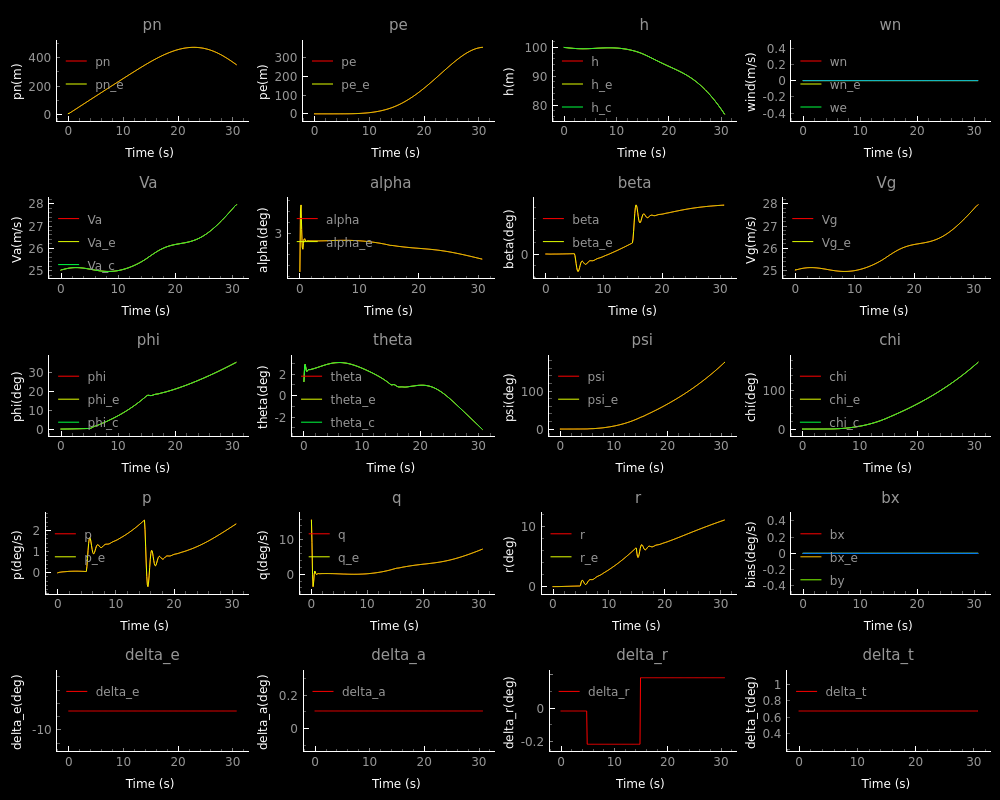

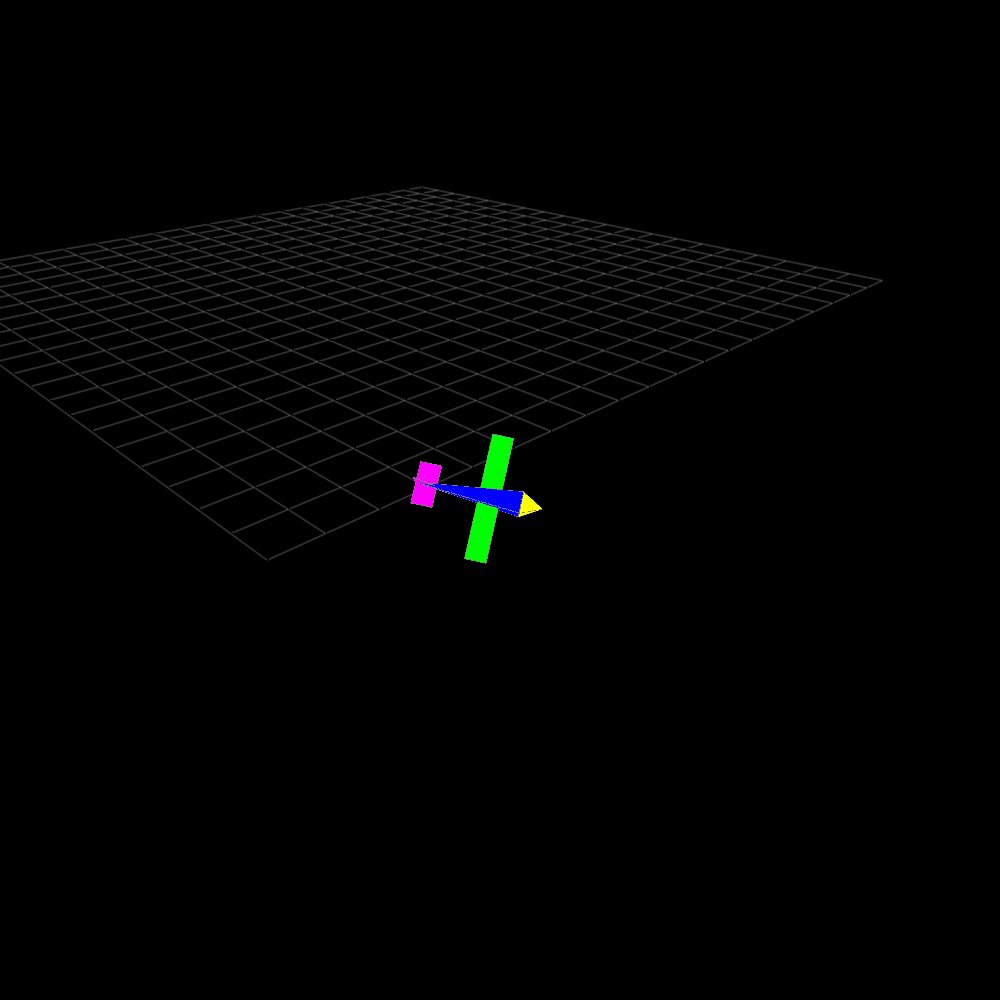

In [5]:
def perturb_rudder(time: float) -> MsgDelta:
    """ Perturb the rudder trim commands by
            -0.2 degrees      5 < time <= 15
            0.2  degrees      5 < time
    """
    # Calculate the trim trajectory
    delta = trim(time)

    # Perturb the control
    if time > 15.:
        delta.rudder += 0.2*np.pi/180. # Perturb up by 0.2 degrees
    elif time > 5:
        delta.rudder += -0.2*np.pi/180. # Perturb down by 0.2 degrees

    # Return the perturbed control
    return delta

# Perturb the elevator
run_sim_and_display(perturb_rudder)

## Problem 4: Effect of the throttle control input
This problem varies the throttle value during flight of the aircraft.  Design a function that will perturb the throttle by 0.2 in the negative direction after 5 seconds and 0.2 in the positive direction after 15 seconds.

### Question: Given the definitions of positive thrust from chapter 4, what behavior do you expect for airspeed,  altitude, and roll rates?
**Answer:** I expect the airspeed to increase as throttle increases, kinda makes sense. The altitude should increase if the airplane is pointed up and roll quicker when rolling.

Run the simulation and verify the expected behavior.

### Question: Was the behavior as expected? If not, what did you observe differently from what you thought you would? Why did this difference occur?
**Answer:** Yes it followed as expected

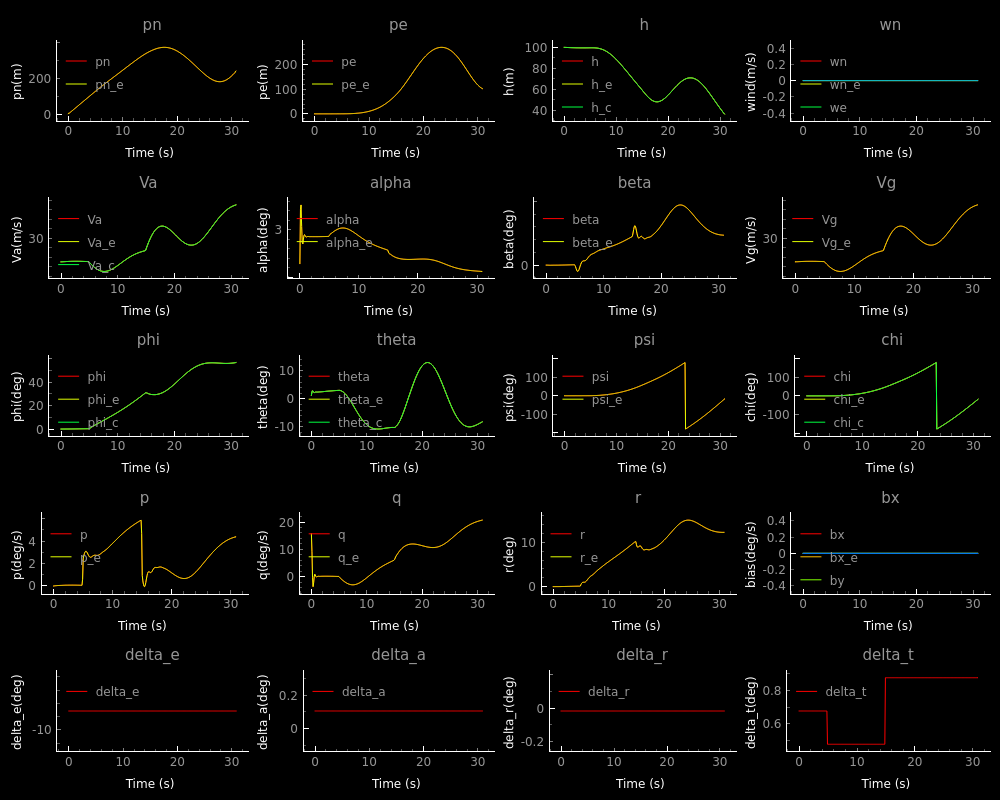

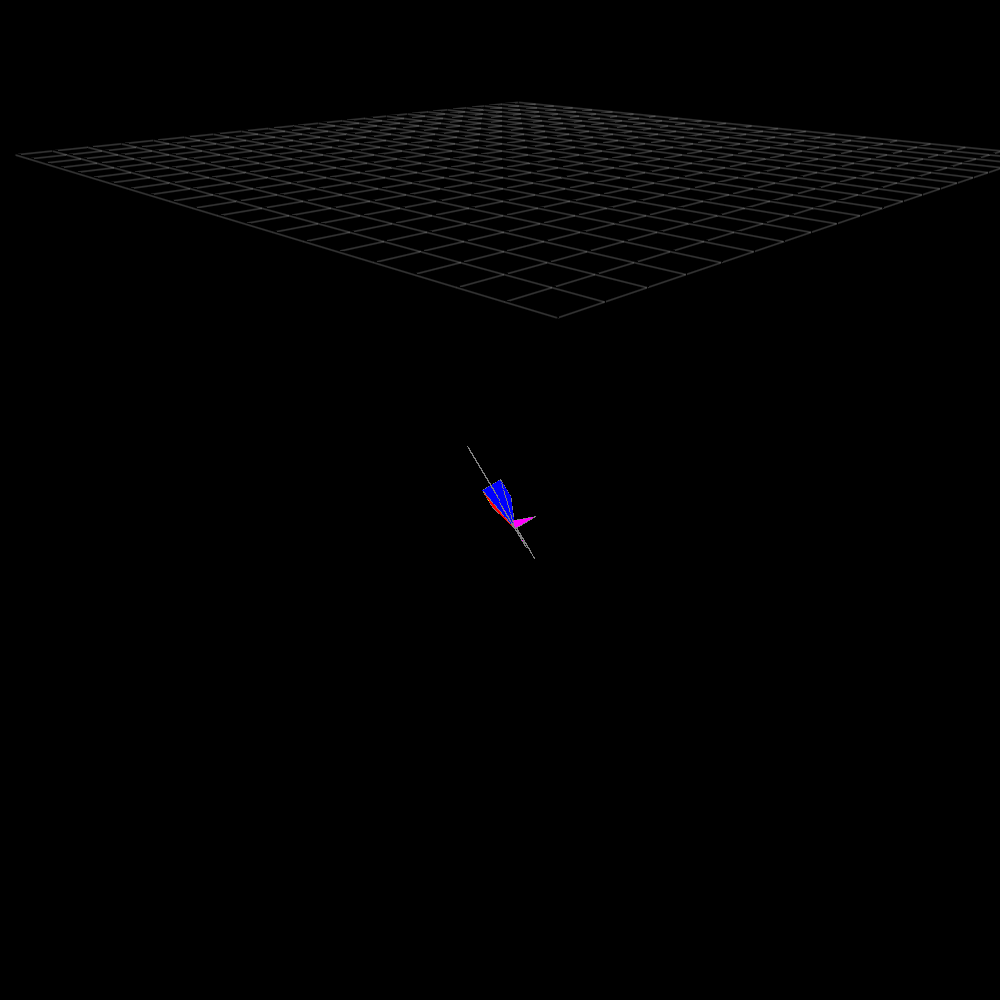

In [6]:
def perturb_throttle(time: float) -> MsgDelta:
    """ Perturb the throttle trim commands by
            -0.2       5 < time <= 15
            0.2        5 < time
    """
    # Calculate the trim trajectory
    delta = trim(time)

    # Perturb the control
    if time > 15.:
        delta.throttle += 0.2 # Perturb up by 0.2
    elif time > 5:
        delta.throttle += -0.2 # Perturb down by 0.2

    # Return the perturbed control
    return delta

# Perturb the elevator
run_sim_and_display(perturb_throttle)

## Problem 5: Wind model implementation
The previous problems did not consider wind. You will now implement the Dryden gust model as defined in Chapter 4.4 of the book. Namely, you will implement the transfer functions in the `__init__` function of `wind_siumulation.py`. 

For example, the parameter *self.u_w* is a transfer function of the form
$$
    H_u(s) = \sigma_u \sqrt{\frac{2V_a}{\pi L_u}} \frac{1}{s+\frac{V_a}{L_u}}
$$
This results in a transfer function with the numerator and denominator defined as
$$
numerator = \sigma_u \sqrt{\frac{2V_a}{\pi L_u}}
$$
$$
denominator = s+\frac{V_a}{L_u}
$$
The numerators and denominators are passed into a `TransferFunction` class that is provided to you by specifying their coefficients. The above equation for $H_u(s)$ can be implemented as follows:
```
a1 = sigma_u*np.sqrt(2.*Va/(np.pi*Lu))
b1 = Va/Lu
self.u_w = TransferFunction(num=np.array([[a1]]),
                            den=np.array([[1, b1]]),
                            Ts=Ts)
```
In `wind_siumulation.py`, you will initialize the following
* `self.u_w` is the transfer function $H_u(s)$
* `self.v_w` is the transfer function $H_v(s)$
* `self.w_w` is the transfer function $H_w(s)$

## Problem 6: Using non-zero wind parameters
You will now run the simulation with a set of parameters for the Dresden gust model from Table 4.1 of the book. Use the medium altitude, moderate turbulence model parameters.

### Question: What effects do you expect to see on the states for the medium altitude, moderate turbulence model as compared to the results of Problem 0?
**Answer:** I expect the simulation to run have random variations in the movement of the aircraft introduced by more noise paramters. There will be variations in the output of the movemnet with gusts.

Run the simulation and verify the expected behavior.

### Question: Was the behavior as expected? If not, what did you observe differently from what you thought you would? Why did this difference occur?
**Answer:** It is simular to expected but created more cariation in VA and wind than I expected with 0 wind but it must be from the gusts

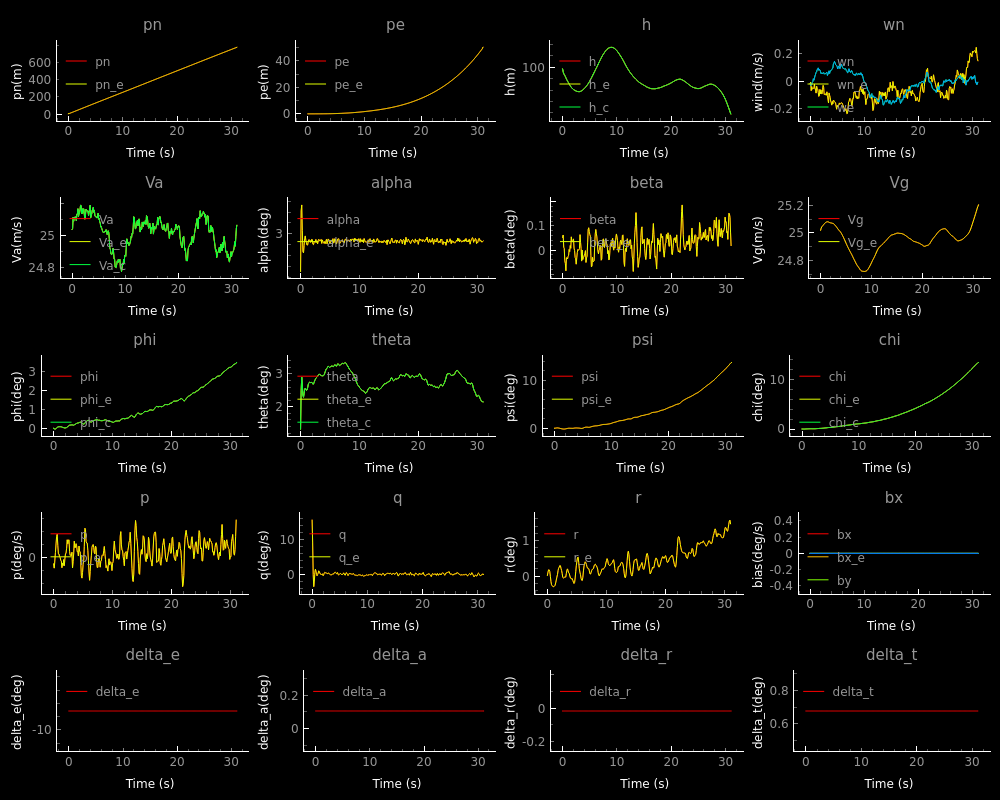

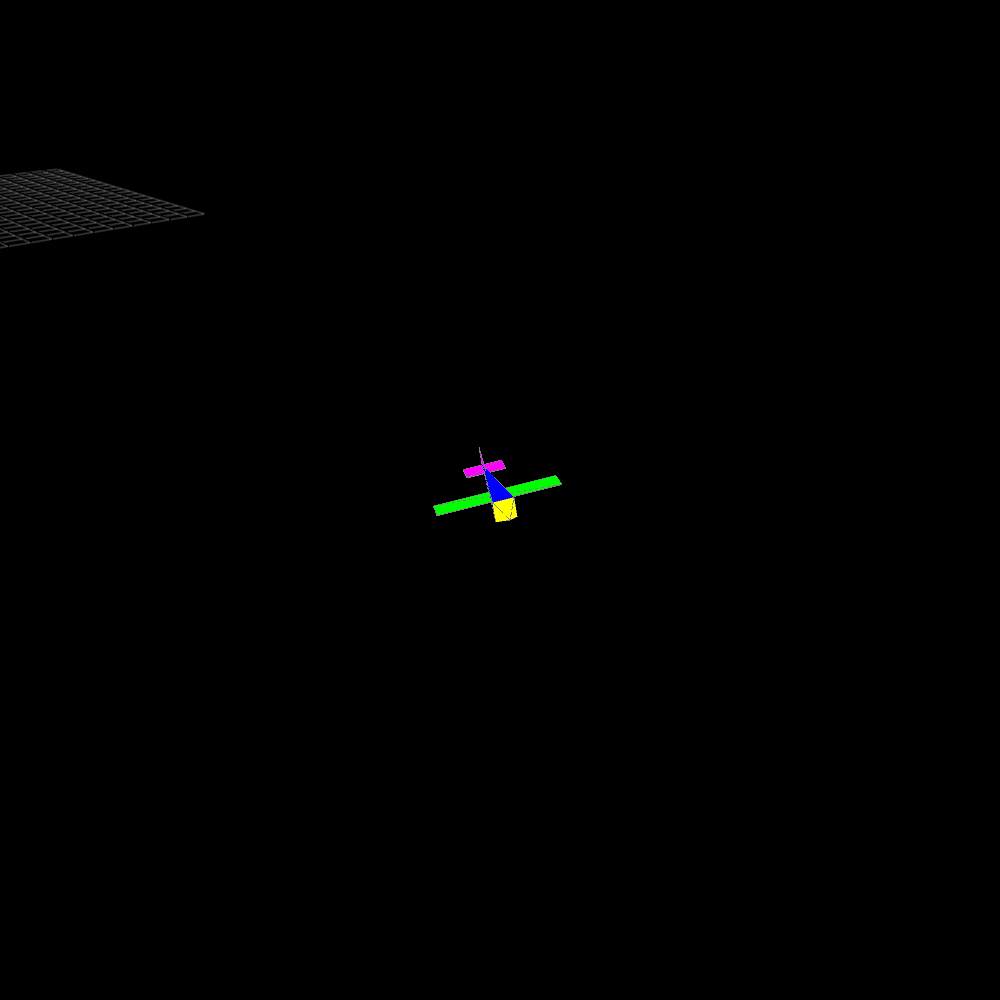

In [7]:
# Run a "straight" trim trajectory with medium altitude, moderate turbulence
gust_params = MsgGustParams()
gust_params.sigma_u = 3 # Set values for the remaining variables
run_sim_and_display(trim, use_wind=True, gust_params=gust_params)

## Static analysis
Run the static code analysis (you must have zero static code analysis errors to get credit). You may not modify the static code analysis configuration files.

### ISORT
Run Isort:
```
python -m isort mav_sim book_assignments
```

Terminal output (should be nothing):

### MyPy
Run MyPy
```
python -m mypy mav_sim/chap2/ mav_sim/chap3/ mav_sim/chap4/ book_assignments
```

Terminal output (should indicate no error):
```
Success: no issues found in 26 source files
```

### Pylint
Run Pylint
```
python -m pylint --jobs 0 --rcfile .pylintrc mav_sim/chap2/ mav_sim/chap3/ mav_sim/chap4/ book_assignments/
```

Terminal output (should indicate `10/10`)
```
-------------------------------------------------------------------
Your code has been rated at 10.00/10 (previous run: 9.92/10, +0.08)
```

## Simple code checking
The following code does not need to change. It is just used to know if the code is implemented properly. The output should not have any lines reading `Failed test!`

In [11]:
from mav_sim.unit_tests.ch4_dynamics_test import run_all_tests, ForcesMomentsTest, MotorThrustTorqueTest, UpdateVelocityTest, WindSimulationTest, GravitationalForceTest, LateralDynamicsTest, LongitudinalDynamicsTest
run_all_tests()

Starting motor_thrust_torque test
End of motor_thrust_torque test

Starting forces_moments test
End of forces_moments test

Starting update_velocity_data test
End of update_velocity_data test

Starting WindSimulation test
End of WindSimulation test


Starting gravitational_force test
Passed test on gravitational_force

Starting lateral_aerodynamics test
Passed test on lateral_aerodynamics

Starting longitudinal_aerodynamics test
Passed test on longitudinal_aerodynamics

Starting forces_moments test
Passed test on forces_moments

Starting motor_thrust_torque test
Passed test on motor_thrust_torque

Starting update_velocity_data test
Passed test on update_velocity_data

Starting WindSimulation test
Passed test on WindSimulation


/home/yocto/class/uav/project/mavsim_python/mav_sim/chap4/mav_dynamics.py:429: RuntimeWarning: invalid value encountered in scalar divide
  return (f_lon, torque_lon)
